## For Colabs

In [1]:
from getpass import getpass
import os

user = "OliverJBoom"
password = getpass('github password')

os.environ['GITHUB_AUTH'] = user + ':' + password
os.chdir("/content")
!rm -rf "/content/acse-9-independent-research-project-OliverJBoom"
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-9-independent-research-project-OliverJBoom.git
os.chdir("acse-9-independent-research-project-OliverJBoom/Src")

github password··········
Cloning into 'acse-9-independent-research-project-OliverJBoom'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 549 (delta 66), reused 56 (delta 25), pack-reused 446
Receiving objects: 100% (549/549), 9.26 MiB | 25.41 MiB/s, done.
Resolving deltas: 100% (304/304), done.


In [2]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
path = "/content/gdrive/My Drive/Chai/Data"

Mounted at /content/gdrive/


## Loading Packages

In [1]:
from deeplearning import *
from models import *
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pickle
from preprocessing import *
from statistics import median
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from utils import *
import warnings

warnings.filterwarnings("ignore")

set_seed(42)

/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


True

### Insuring that training is done on GPU if available

In [2]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


## Loading Data

In [3]:
path = "Data/Commodity_Data/"
universe_dict = universe_select(path, "Cu")
use_lg_returns = False

## Preprocessing

In [4]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)

# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)

# Making sure that all the points in the window have consistent length
universe_dict = truncate_window_length(universe_dict)

# Generating the dataset
if use_lg_returns:
    # Lg Returns Only
    df_full = generate_dataset(universe_dict, lg_returns_only=True, price_only=False)
    target_col = "cu_lme"

else:
    # Price Only
    df_full = generate_dataset(universe_dict, lg_returns_only=False, price_only=True)
    target_col = "price_cu_lme"

# Set to False initially
PCA_used = False

Included Instrument:
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci


In [5]:
# Visualise the plots
# visualise_universe(universe_dict)

In [6]:
df_full.head(15)
# df_full.tail(5)

,price_cu_shfe,price_cu_lme,price_cu_comex_p,price_cu_comex_s,price_peso,price_sol,price_bdi,price_ted,price_vix,price_skew,price_gsci
date,,,,,,,,,,,
2006-09-13,69540.0,7484.5,3.3925,15748.0,537.35,3.2530,4129.0,4.901,11.18,120.44,438.38855
2006-09-14,71350.0,7439.0,3.3820,14180.0,537.73,3.2475,4207.0,4.926,11.55,119.47,433.72522
2006-09-15,69400.0,7281.0,3.3165,14775.0,537.10,3.2480,4258.0,4.939,11.76,135.25,431.58291
2006-09-18,69830.0,7459.0,3.4180,15263.0,537.10,3.2450,4279.0,4.949,11.78,127.35,434.97293
2006-09-19,71470.0,7516.0,3.3755,17523.0,537.10,3.2450,4275.0,4.948,11.98,125.03,426.51240
2006-09-20,69610.0,7474.0,3.3700,18091.0,537.80,3.2450,4244.0,4.937,11.39,122.71,418.32234
2006-09-21,70170.0,7602.0,3.4220,19546.0,539.70,3.2480,4200.0,4.921,12.25,119.68,423.56908
2006-09-22,71170.0,7601.0,3.4395,20627.0,538.50,3.2470,4136.0,4.924,12.59,118.86,418.01647
2006-09-25,71130.0,7560.0,3.4475,20978.0,539.30,3.2490,4069.0,4.907,12.12,120.75,418.93144


### Normalizing the dataset

In [7]:
# Forecast length
# forecast_length = 5
forecast_length = 22

# Data scaling
scaler_data_X = MinMaxScaler()
scaler_data_y = MinMaxScaler()

df_target = df_full[[target_col]]

data_X = scaler_data_X.fit_transform(df_full)[:-forecast_length, :]
# Need to have an independent scaler for inverse_transforming later
data_y = scaler_data_y.fit_transform(df_target)

# Offset target one forecast length
data_y = shift(data_y.ravel(), -forecast_length)[:-forecast_length]
# Check shape assert(data_X.shape[:, 0]== data_y.shape[0])

### PCA

In [8]:
# Reducing the dataset to containing a threshold amount of variance
n_dim = dimension_selector(data_X, thresh=0.95)
data_X = dimension_reduce(data_X, n_dim)

PCA_used = True

Number of dimensions: 6
Explained Variance: [0.49037062 0.23266073 0.1438431  0.0479405  0.02769351 0.02200757] 
Explained Variance Sum: 0.9645160396956036


### Slicing Series into Windows

In [9]:
# The input size of each time series window
series_length = 250
  
data_X, data_y = slice_series(data_X, data_y, series_length, dataset_pct=0.2)

### Hyperparameters

In [10]:
# Hyperparameters
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 32
test_batch_size = 1000
# series_length = 100

# Training Parameters
n_epochs = 1000
patience = 250
disp_freq = 1
fig_disp_freq = 1


# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 128
hidden_dim_2 = 8
num_layers = 2
output_dim = 1
dropout = 0.2

### Initialising the model

In [11]:
# class DeepLearning():
#     """Class to perform training and validation for a given model
    
#     :param model: the neural network model
#     :param data_X: the training dataset
#     :param data_y: the target dataset
#     :param n_epochs: the number of epochs of training
#     :param optimiser: the type of optimiser used
#     :param batch_size: the batch size
#     :param loss_function: the loss function used
#     :param device: running on cpu or CUDA
#     :param seed: the random seed set
#     :param debug: whether to print some parameters for checking
#     :param disp_freq: the frequency that training/validation metrics will be printed
#     :param fig_disp_freq: the frequency that training/validation prediction figures will be made
#     :param early_stop: whether early stopping is utilized
#     :param early_verbose: whether to print out the early stopping counter
#     :param patience: the amount of epochs without improvement before stopping
#     :param rel_tol: the relative improvement percentage that must be achieved
    
#     :type patience: int
#     :type model: LSTM
#     :type data_X: np.array
#     :type data_y: np.array
#     :type n_epochs: int
#     :type optimiser: torch.optim
#     :type batch_size: int
#     :type loss_function: torch.nn.modules.loss
#     :type device: string
#     :type seed: int
#     :type debug: bool
#     :type disp_freq: int
#     :type fig_disp_freq: int
#     :type early_stop: bool
#     :type early_verbose: bool
#     :type patience: int
#     :type rel_tol: float
#     """
#     def __init__(self, model, data_X, data_y,
#                  n_epochs,
#                  optimiser,
#                  batch_size,
#                  loss_function=torch.nn.MSELoss(size_average=False),
#                  device="cpu",
#                  seed=42,
#                  debug = True,
#                  disp_freq=20,
#                  fig_disp_freq=50,
#                  early_stop=True,
#                  early_verbose=False,
#                  patience=50,
#                  rel_tol=0):

#         # The neural network architecture
#         self.model = model

#         # The optimiser for gradient descent
#         self.optimiser = optimiser

#         # Dataframe of training values
#         self.data_X = data_X

#         # Dataframe of target values
#         self.data_y = data_y

#         # The number of epochs
#         self.n_epochs = n_epochs

#         #self.optimiser = optimiser
#         self.loss_function = loss_function

#         # Whether to run on cpu or gpu
#         self.device = device

#         # The random seed to set
#         self.seed = seed

#         # To activate debug mode
#         self.debug = debug

#         # For training/val logs
#         self.logs = {}

#         # The array of predicted lists for each batch for training
#         self.train_predictions = None

#         # The array of predicted lists for each batch for validation
#         self.val_predictions = None

#         # The array of predicted lists for each batch for validation
#         self.test_predictions = None

#         # The data
#         self.X_train = None
#         self.X_val = None
#         self.X_test = None

#         # The targets
#         self.y_train = None
#         self.y_val = None
#         self.y_test = None

#         # Val data loader
#         self.val_loader = None

#         # Test data loader
#         self.test_loader = None

#         # Batch size
#         self.batch_size = batch_size

#         # How frequently the loss is printed
#         self.disp_freq = disp_freq

#         # How frequently a figure is plotted
#         self.fig_disp_freq = fig_disp_freq

#         # Storing the best model
#         self.best_model = self.model

#         # Dummy variable for inspecting quantities
#         self.inspect = None

#         # For running dataloaders on CUDA
#         self.pin_memory = False

#         self.early_stop = early_stop

#         if self.early_stop:
#             self.early = early_stopping(patience=patience, rel_tol=rel_tol, verbose=early_verbose)
    
#         self.MTL = False

#     def train_val_test(self):
#         """Splits the dataframes in to a training, validation
#         and test set and creates torch tensors from the underlying
#         numpy arrays"""
#         # Splitting the sets into train, test and validation
#         self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data_X, self.data_y, test_size=0.2, shuffle=False)

#         self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.25, shuffle=False)

#         if self.debug:
#             print("Train Length: \t\t%i\nValidation Length: \t%i\nTest Length:\t\t%i"
#                   % (len(X_train), len(X_val), len(X_test)))

#         # Tensor of training data
#         self.X_train = torch.from_numpy(self.X_train).float()
#         self.y_train = torch.from_numpy(self.y_train).float()

#         # Tensor of training labels
#         self.X_val = torch.from_numpy(self.X_val).float()
#         self.y_val = torch.from_numpy(self.y_val).float()

#         #  Tensor of test data
#         self.X_test = torch.from_numpy(self.X_test).float()
#         self.y_test = torch.from_numpy(self.y_test).float()

#         # Size Check
#         if self.debug:
#             print("\nInitial Size Check:")
#             self.size_check()
            
#         if self.y_test.dim()!=1:
#             self.MTL = True

#     def size_check(self):
#         """Checks the size of the datasets"""
#         if self.debug:
#             print("\nX Train Shape:\t\t", self.X_train.size())
#             print("X Val Shape:\t\t", self.X_val.size())
#             print("X Test Shape:\t\t", self.X_test.size())

#             print("\ny Train Shape:\t\t", self.y_train.size())
#             print("y Val Shape:\t\t", self.y_val.size())
#             print("y Test Shape:\t\t", self.y_test.size())

#     def create_data_loaders(self):
#         """Forms iterators to pipeline in the data
#         """
#         # Create tensor datasets
#         train_dataset = TensorDataset(self.X_train, self.y_train)
#         val_dataset = TensorDataset(self.X_val, self.y_val)
#         test_dataset = TensorDataset(self.X_test, self.y_test)

#         if self.device =='cuda': self.pin_memory=True

#         # Data loaders
#         self.train_loader = DataLoader(dataset=train_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8,  pin_memory=self.pin_memory)
#         self.val_loader = DataLoader(dataset=val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8,  pin_memory=self.pin_memory)
#         self.test_loader = DataLoader(dataset=test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8,  pin_memory=self.pin_memory)


#     def train(self, train_loader):
#         """Performs a single training cycle and returns the
#         loss metric for the training dataset
        
#         :param train_loader: the iterator that feeds in the training data
#         :type train_loader: torch.utils.data.dataloader.DataLoader

#         :return: the error metric for that epoch
#         :rtype: float
#         """
#         # Sets the model to train mode
#         self.model.train()

#         train_loss = 0.

#         # Selecting the number of output features
#         if self.MTL: 
#             pred_list = np.empty((0, self.y_test.shape[1]))
#         else: 
#             pred_list = []
        
#         # The data loader creates batches of data to train
#         for i_batch, (X_train_batch, y_train_batch) in enumerate(train_loader):  

#             # Sending the data to GPU if available
#             X_train_batch = X_train_batch.to(self.device)
#             y_train_batch = y_train_batch.to(self.device)

#             # Zeros the gradients
#             self.optimiser.zero_grad()

#             # Need to set seed here to make deterministic
#             set_seed(42)

#             # Perform forward pass
#             y_pred = self.model(X_train_batch)

#             # Calculate loss for the batch
#             loss = self.loss_function(y_pred, y_train_batch)

#             # Perform backward pass
#             loss.backward()
            
#             # Adding the predictions for this batch to prediction list
#             pred_list = np.concatenate([pred_list, y_pred.detach().numpy()], axis=0)

#             # Calculate the training loss
#             train_loss += (loss * X_train_batch.size()[0]).detach().cpu().numpy()

#             # Update Parameters
#             self.optimiser.step()            
        
#         # Saving the predictions
#         self.train_predictions = pred_list
            
#         return train_loss/len(train_loader.dataset.tensors[0])


#     def validate(self, val_loader):
#         """Evaluates the performance of the network
#         on unseen validation data
        
#         :param val_loader: the iterator that feeds in the validation data
#         :type val_loader: torch.utils.data.dataloader.DataLoader

#         :return: the error metric for that epoch
#         :rtype: float
#         """
#         # Set the model to evaluate mode
#         self.model.eval()

#         val_loss = 0.

#         # List of each batch predictions
#         if self.MTL: 
#             val_pred_list = np.empty((0, self.y_test.shape[1]))
#         else: 
#             val_pred_list = []

#         # The data loader creates batches of data to validate
#         for X_val_batch, y_val_batch in val_loader:

#             # Ensures that the gradients are not updated
#             with torch.no_grad():

#                 # Sending the data to GPU if available
#                 X_val_batch = X_val_batch.to(self.device)
#                 y_val_batch = y_val_batch.to(self.device)

#                 # Perform forward pass
#                 y_pred = self.model(X_val_batch)

#                 # Calculate loss for the batch
#                 loss = self.loss_function(y_pred, y_val_batch)

#                 # Adding the predictions for this batch to prediction list
#                 val_pred_list = np.concatenate([val_pred_list, y_pred.detach().numpy()], axis=0)
            
#                 # Calculate the validation loss
#                 val_loss += (loss * X_val_batch.size()[0]).detach().cpu().numpy()

#         # Converting an array of batches of predictions to a list of predictions
#         self.val_predictions = val_pred_list

#         return val_loss/len(val_loader.dataset.tensors[0])


#     def evaluate(self, model, test_loader):
#         """Evaluates the performance of the network 
#         on given data for a given model
        
#         A lot of overlap of code with validation. Only kept separate
#         due to inspection of attibutes made easier when running simulations
#         if kept separate
        
#         :param test_loader: the iterator that feeds in the data of choice
#         :type test_loader: torch.utils.data.dataloader.DataLoader

#         :return: the error metric for that dataset
#         :rtype: float
#         """
#         # Set the model to evaluate mode
#         model = model.eval()

#         test_loss = 0.

#         # List of each batch predictions
#         test_pred_list = []

#         # The data loader creates batches of data to validate
#         for X_test_batch, y_test_batch in test_loader:

#             # Ensures that the gradients are not updated
#             with torch.no_grad():

#                 # Sending the data to GPU if available
#                 X_test_batch = X_test_batch.to(self.device)
#                 y_test_batch = y_test_batch.to(self.device)

#                 # Perform forward pass
#                 y_pred = model(X_test_batch)

#                 # Calculate loss for the batch
#                 loss = self.loss_function(y_pred, y_test_batch)

#                 # Adding the predictions for this batch to prediction list
#                 test_pred_list.append(y_pred)

#                 # Calculate the validation loss
#                 test_loss += (loss * X_test_batch.size()[0]).detach().cpu().numpy()

#         # Converting an array of batches of predictions to a list of predictions
#         self.test_predictions = [single_pred for batch in test_pred_list for single_pred in batch.detach().cpu().numpy()]

#         return test_loss/len(test_loader.dataset.tensors[0])


#     def live_pred_plot(self):
#         """Plots the training predictions, validation predictions
#         and the live training/validation losses
#         """        
#         if self.MTL:
#             fig, ax = plt.subplots(1, 4, figsize= (20, 5))

#             ax[0].set_title("Training Predictions")
#             ax[0].plot(self.train_predictions[:, 0], label="Predicted")
#             ax[0].plot(self.y_train.numpy()[:, 0],label="Observed")
#             ax[0].legend()

#             ax[1].set_title("Validation Predictions")
#             ax[1].plot(self.val_predictions, label="Predicted")
#             ax[1].plot(self.y_val.numpy(), '--', label="Observed")
#             ax[1].legend()

#             ax[2].set_title("Loss Plots")
#             ax[2].plot(self.logs['Training Loss'], label="Training Loss")
#             ax[2].plot(self.logs['Validation Loss'], label="Validation Loss")
#             ax[2].legend()

#             ax[3].set_title("Universe of IMs")
#             ax[3].plot(self.train_predictions, label="Predicted")
#             ax[3].plot(self.y_train.numpy(), '--',label="Observed")
#             ax[3].legend()
#             plt.show()
            
#         else: 
#             fig, ax = plt.subplots(1, 3, figsize= (20, 5))

#             ax[0].set_title("Training Predictions")
#             ax[0].plot(self.train_predictions, label="Predicted")
#             ax[0].plot(self.y_train.numpy(), label="Observed")
#             ax[0].legend()

#             ax[1].set_title("Validation Predictions")
#             ax[1].plot(self.val_predictions, label="Predicted")
#             ax[1].plot(self.y_val.numpy(), label="Observed")
#             ax[1].legend()

#             ax[2].set_title("Loss Plots")
#             ax[2].plot(self.logs['Training Loss'], label="Training Loss")
#             ax[2].plot(self.logs['Validation Loss'], label="Validation Loss")
#             ax[2].legend()
#             plt.show()

#     def training_wrapper(self):
#         """The wrapper that performs the training and validation
#         """
#         # start timer
#         start_time = time.time()

#         # set seed
#         set_seed(int(self.seed))

#         # Create data loaders
#         self.create_data_loaders()

#         train_log = []
#         val_log = []

#         # The best validation score tracker
#         self.best_val_score = np.inf

#         # Begin training
#         for epoch in range(self.n_epochs):

#             live_logs = {}

#             train_loss = self.train(self.train_loader)
#             val_loss = self.validate(self.val_loader)

#             # Saving the best model
#             if val_loss.item() <= self.best_val_score:
#                 self.best_model = deepcopy(self.model)
#                 self.best_val_score = val_loss.item()

#             train_log.append(train_loss.item())
#             val_log.append(val_loss.item())
#             self.logs["Training Loss"] = train_log
#             self.logs["Validation Loss"] = val_log
#             self.logs["Time"] = time.time() - start_time

#             # Checking stopping criteria
#             if self.early_stop:
#                 self.early(val_loss.item())
#                 if self.early.stop:
#                     print("Early Stopping")
#                     self.model = self.best_model
#                     break
            
            
#             if (epoch % self.disp_freq == 0):
#                 print("Epoch: %i Train: %.5f Val: %.5f  Time: %.3f  Best Val: %.5f" % (epoch, train_loss.item(),
#                                                           val_loss.item(), (time.time() - start_time), self.best_val_score))

#             if (epoch % self.fig_disp_freq == 0):
#                 self.live_pred_plot()

#         # Storing the best model
#         self.model = self.best_model

In [12]:
# class DeepLearning():
#     """Class to perform training and validation for a given model
    
#     :param model: the neural network model
#     :param data_X: the training dataset
#     :param data_y: the target dataset
#     :param n_epochs: the number of epochs of training
#     :param optimiser: the type of optimiser used
#     :param batch_size: the batch size
#     :param loss_function: the loss function used
#     :param device: running on cpu or CUDA
#     :param seed: the random seed set
#     :param debug: whether to print some parameters for checking
#     :param disp_freq: the frequency that training/validation metrics will be printed
#     :param fig_disp_freq: the frequency that training/validation prediction figures will be made
#     :param early_stop: whether early stopping is utilized
#     :param early_verbose: whether to print out the early stopping counter
#     :param patience: the amount of epochs without improvement before stopping
#     :param rel_tol: the relative improvement percentage that must be achieved
    
#     :type patience: int
#     :type model: LSTM
#     :type data_X: np.array
#     :type data_y: np.array
#     :type n_epochs: int
#     :type optimiser: torch.optim
#     :type batch_size: int
#     :type loss_function: torch.nn.modules.loss
#     :type device: string
#     :type seed: int
#     :type debug: bool
#     :type disp_freq: int
#     :type fig_disp_freq: int
#     :type early_stop: bool
#     :type early_verbose: bool
#     :type patience: int
#     :type rel_tol: float
#     """
#     def __init__(self, model, data_X, data_y,
#                  n_epochs,
#                  optimiser,
#                  batch_size,
#                  loss_function=torch.nn.MSELoss(size_average=False),
#                  device="cpu",
#                  seed=42,
#                  debug = True,
#                  disp_freq=20,
#                  fig_disp_freq=50,
#                  early_stop=True,
#                  early_verbose=False,
#                  patience=50,
#                  rel_tol=0):

#         # The neural network architecture
#         self.model = model

#         # The optimiser for gradient descent
#         self.optimiser = optimiser

#         # Dataframe of training values
#         self.data_X = data_X

#         # Dataframe of target values
#         self.data_y = data_y

#         # The number of epochs
#         self.n_epochs = n_epochs

#         #self.optimiser = optimiser
#         self.loss_function = loss_function

#         # Whether to run on cpu or gpu
#         self.device = device

#         # The random seed to set
#         self.seed = seed

#         # To activate debug mode
#         self.debug = debug

#         # For training/val logs
#         self.logs = {}

#         # The array of predicted lists for each batch for training
#         self.train_predictions = None

#         # The array of predicted lists for each batch for validation
#         self.val_predictions = None

#         # The array of predicted lists for each batch for validation
#         self.test_predictions = None

#         # The data
#         self.X_train = None
#         self.X_val = None
#         self.X_test = None

#         # The targets
#         self.y_train = None
#         self.y_val = None
#         self.y_test = None

#         # Val data loader
#         self.val_loader = None

#         # Test data loader
#         self.test_loader = None

#         # Batch size
#         self.batch_size = batch_size

#         # How frequently the loss is printed
#         self.disp_freq = disp_freq

#         # How frequently a figure is plotted
#         self.fig_disp_freq = fig_disp_freq

#         # Storing the best model
#         self.best_model = self.model

#         # Dummy variable for inspecting quantities
#         self.inspect = None

#         # For running dataloaders on CUDA
#         self.pin_memory = False

#         self.early_stop = early_stop

#         if self.early_stop:
#             self.early = early_stopping(patience=patience, rel_tol=rel_tol, verbose=early_verbose)
    
#         self.MTL = False

#     def train_val_test(self):
#         """Splits the dataframes in to a training, validation
#         and test set and creates torch tensors from the underlying
#         numpy arrays"""
#         # Splitting the sets into train, test and validation
#         self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data_X, self.data_y, test_size=0.2, shuffle=False)

#         self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.25, shuffle=False)

#         if self.debug:
#             print("Train Length: \t\t%i\nValidation Length: \t%i\nTest Length:\t\t%i"
#                   % (len(X_train), len(X_val), len(X_test)))

#         # Tensor of training data
#         self.X_train = torch.from_numpy(self.X_train).float()
#         self.y_train = torch.from_numpy(self.y_train).float()

#         # Tensor of training labels
#         self.X_val = torch.from_numpy(self.X_val).float()
#         self.y_val = torch.from_numpy(self.y_val).float()

#         #  Tensor of test data
#         self.X_test = torch.from_numpy(self.X_test).float()
#         self.y_test = torch.from_numpy(self.y_test).float()

#         # Size Check
#         if self.debug:
#             print("\nInitial Size Check:")
#             self.size_check()
            
#         if self.y_test.dim()!=1:
#             self.MTL = True

#     def size_check(self):
#         """Checks the size of the datasets"""
#         if self.debug:
#             print("\nX Train Shape:\t\t", self.X_train.size())
#             print("X Val Shape:\t\t", self.X_val.size())
#             print("X Test Shape:\t\t", self.X_test.size())

#             print("\ny Train Shape:\t\t", self.y_train.size())
#             print("y Val Shape:\t\t", self.y_val.size())
#             print("y Test Shape:\t\t", self.y_test.size())

#     def create_data_loaders(self):
#         """Forms iterators to pipeline in the data
#         """
#         # Create tensor datasets
#         train_dataset = TensorDataset(self.X_train, self.y_train)
#         val_dataset = TensorDataset(self.X_val, self.y_val)
#         test_dataset = TensorDataset(self.X_test, self.y_test)

#         if self.device =='cuda': self.pin_memory=True

#         # Data loaders
#         self.train_loader = DataLoader(dataset=train_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8,  pin_memory=self.pin_memory)
#         self.val_loader = DataLoader(dataset=val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8,  pin_memory=self.pin_memory)
#         self.test_loader = DataLoader(dataset=test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8,  pin_memory=self.pin_memory)


#     def train(self, train_loader):
#         """Performs a single training cycle and returns the
#         loss metric for the training dataset
        
#         :param train_loader: the iterator that feeds in the training data
#         :type train_loader: torch.utils.data.dataloader.DataLoader

#         :return: the error metric for that epoch
#         :rtype: float
#         """
#         # Sets the model to train mode
#         self.model.train()

#         train_loss = 0.

#         # Selecting the number of output features
#         if self.MTL: 
#             pred_list = np.empty((0, self.y_test.shape[1]))
#         else: 
#             pred_list = np.empty((0, 1))
        
#         # The data loader creates batches of data to train
#         for i_batch, (X_train_batch, y_train_batch) in enumerate(train_loader):  

#             # Sending the data to GPU if available
#             X_train_batch = X_train_batch.to(self.device)
#             y_train_batch = y_train_batch.to(self.device)

#             # Zeros the gradients
#             self.optimiser.zero_grad()

#             # Need to set seed here to make deterministic
#             set_seed(42)

#             # Perform forward pass
#             y_pred = self.model(X_train_batch)

#             # Calculate loss for the batch
#             loss = self.loss_function(y_pred, y_train_batch)

#             # Perform backward pass
#             loss.backward()
            
#             self.inspect = y_pred.detach().numpy()
            
#             # Adding the predictions for this batch to prediction list
#             pred_list = np.concatenate([pred_list, y_pred.detach().numpy()], axis=0)

#             # Calculate the training loss
#             train_loss += (loss * X_train_batch.size()[0]).detach().cpu().numpy()

#             # Update Parameters
#             self.optimiser.step()            
        
#         # Saving the predictions
#         self.train_predictions = pred_list
            
#         return train_loss/len(train_loader.dataset.tensors[0])


#     def validate(self, val_loader):
#         """Evaluates the performance of the network
#         on unseen validation data
        
#         :param val_loader: the iterator that feeds in the validation data
#         :type val_loader: torch.utils.data.dataloader.DataLoader

#         :return: the error metric for that epoch
#         :rtype: float
#         """
#         # Set the model to evaluate mode
#         self.model.eval()

#         val_loss = 0.

#         # List of each batch predictions
#         if self.MTL: 
#             val_pred_list = np.empty((0, self.y_test.shape[1]))
#         else: 
#             val_pred_list = np.empty((0, 1))

#         # The data loader creates batches of data to validate
#         for X_val_batch, y_val_batch in val_loader:

#             # Ensures that the gradients are not updated
#             with torch.no_grad():

#                 # Sending the data to GPU if available
#                 X_val_batch = X_val_batch.to(self.device)
#                 y_val_batch = y_val_batch.to(self.device)

#                 # Perform forward pass
#                 y_pred = self.model(X_val_batch)

#                 # Calculate loss for the batch
#                 loss = self.loss_function(y_pred, y_val_batch)

#                 # Adding the predictions for this batch to prediction list
#                 val_pred_list = np.concatenate([val_pred_list, y_pred.detach().numpy()], axis=0)
            
#                 # Calculate the validation loss
#                 val_loss += (loss * X_val_batch.size()[0]).detach().cpu().numpy()

#         # Converting an array of batches of predictions to a list of predictions
#         self.val_predictions = val_pred_list

#         return val_loss/len(val_loader.dataset.tensors[0])


#     def evaluate(self, model, test_loader):
#         """Evaluates the performance of the network 
#         on given data for a given model
        
#         A lot of overlap of code with validation. Only kept separate
#         due to inspection of attibutes made easier when running simulations
#         if kept separate
        
#         :param test_loader: the iterator that feeds in the data of choice
#         :type test_loader: torch.utils.data.dataloader.DataLoader

#         :return: the error metric for that dataset
#         :rtype: float
#         """
#         # Set the model to evaluate mode
#         model = model.eval()

#         test_loss = 0.

#         # Selecting the number of output features
#         if self.MTL: 
#             test_pred_list = np.empty((0, self.y_test.shape[1]))
#         else: 
#             test_pred_list = np.empty((0, 1))

#         # The data loader creates batches of data to validate
#         for X_test_batch, y_test_batch in test_loader:

#             # Ensures that the gradients are not updated
#             with torch.no_grad():

#                 # Sending the data to GPU if available
#                 X_test_batch = X_test_batch.to(self.device)
#                 y_test_batch = y_test_batch.to(self.device)

#                 # Perform forward pass
#                 y_pred = model(X_test_batch)

#                 # Calculate loss for the batch
#                 loss = self.loss_function(y_pred, y_test_batch)

#                 # Adding the predictions for this batch to prediction list
#                 test_pred_list = np.concatenate([val_pred_list, y_pred.detach().numpy()], axis=0)

#                 # Calculate the validation loss
#                 test_loss += (loss * X_test_batch.size()[0]).detach().cpu().numpy()

#         # Converting an array of batches of predictions to a list of predictions
#         self.test_predictions = test_pred_list

#         return test_loss/len(test_loader.dataset.tensors[0])


#     def live_pred_plot(self):
#         """Plots the training predictions, validation predictions
#         and the live training/validation losses
#         """        
#         if self.MTL:
#             fig, ax = plt.subplots(1, 4, figsize= (20, 5))

#             ax[0].set_title("Training Predictions")
#             ax[0].plot(self.train_predictions, label="Predicted")
#             ax[0].plot(self.y_train.numpy(), '--',label="Observed")
#             ax[0].legend()

#             ax[1].set_title("Validation Predictions")
#             ax[1].plot(self.val_predictions, label="Predicted")
#             ax[1].plot(self.y_val.numpy(), '--', label="Observed")
#             ax[1].legend()

#             ax[2].set_title("Loss Plots")
#             ax[2].plot(self.logs['Training Loss'], label="Training Loss")
#             ax[2].plot(self.logs['Validation Loss'], label="Validation Loss")
#             ax[2].legend()

#             ax[3].set_title("Single Metal Inspection")
#             ax[3].plot(self.train_predictions[:, 0], label="Predicted")
#             ax[3].plot(self.y_train.numpy()[:, 0],label="Observed")
#             ax[3].legend()
#             plt.show()
            
#         else: 
#             fig, ax = plt.subplots(1, 3, figsize= (20, 5))

#             ax[0].set_title("Training Predictions")
#             ax[0].plot(self.train_predictions, label="Predicted")
#             ax[0].plot(self.y_train.numpy(), label="Observed")
#             ax[0].legend()

#             ax[1].set_title("Validation Predictions")
#             ax[1].plot(self.val_predictions, label="Predicted")
#             ax[1].plot(self.y_val.numpy(), label="Observed")
#             ax[1].legend()

#             ax[2].set_title("Loss Plots")
#             ax[2].plot(self.logs['Training Loss'], label="Training Loss")
#             ax[2].plot(self.logs['Validation Loss'], label="Validation Loss")
#             ax[2].legend()
#             plt.show()

#     def training_wrapper(self):
#         """The wrapper that performs the training and validation
#         """
#         # start timer
#         start_time = time.time()

#         # set seed
#         set_seed(int(self.seed))

#         # Create data loaders
#         self.create_data_loaders()

#         train_log = []
#         val_log = []

#         # The best validation score tracker
#         self.best_val_score = np.inf

#         # Begin training
#         for epoch in range(self.n_epochs):

#             live_logs = {}

#             train_loss = self.train(self.train_loader)
#             val_loss = self.validate(self.val_loader)

#             # Saving the best model
#             if val_loss.item() <= self.best_val_score:
#                 self.best_model = deepcopy(self.model)
#                 self.best_val_score = val_loss.item()

#             train_log.append(train_loss.item())
#             val_log.append(val_loss.item())
#             self.logs["Training Loss"] = train_log
#             self.logs["Validation Loss"] = val_log
#             self.logs["Time"] = time.time() - start_time

#             # Checking stopping criteria
#             if self.early_stop:
#                 self.early(val_loss.item())
#                 if self.early.stop:
#                     print("Early Stopping")
#                     self.model = self.best_model
#                     break
            
            
#             if (epoch % self.disp_freq == 0):
#                 print("Epoch: %i Train: %.5f Val: %.5f  Time: %.3f  Best Val: %.5f" % (epoch, train_loss.item(),
#                                                           val_loss.item(), (time.time() - start_time), self.best_val_score))

#             if (epoch % self.fig_disp_freq == 0):
#                 self.live_pred_plot()

#         # Storing the best model
#         self.model = self.best_model

In [14]:
model = LSTM_deep(num_features=num_features, 
             hidden_dim=hidden_dim, 
             hidden_dim_2=hidden_dim_2,
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers, 
             device=device,
             dropout=dropout)

model.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 6 
hidden_dim 128
series_length 250 
batch_size 32
output_dim 1 
num_layers 2
data_X  (416, 250, 6) 
data_y (416,)


In [15]:
# Loading trained model
# model = torch.load("/content/gdrive/My Drive/Chai/Models/Pths/" + "partial_dataset_LSTM_0_1206.pth")
# model.to(device)

Epoch: 0 Train: 204.91001 Val: 221.22467  Time: 7.284  Best Val: 221.22467


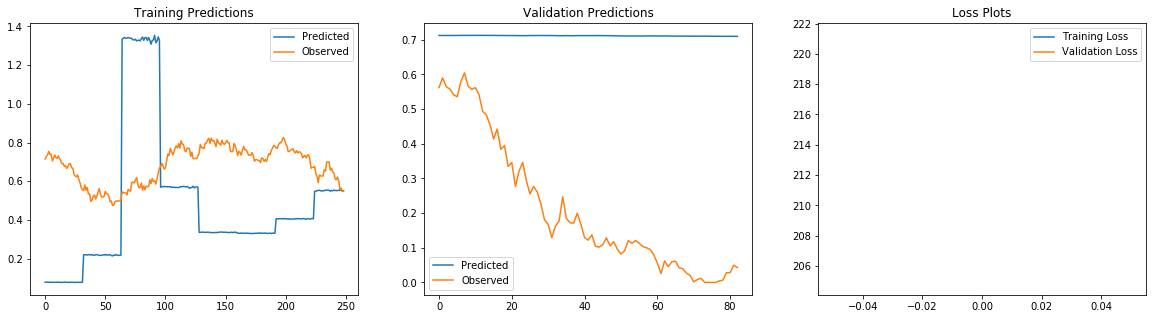

Epoch: 1 Train: 27.02357 Val: 209.52321  Time: 12.288  Best Val: 209.52321


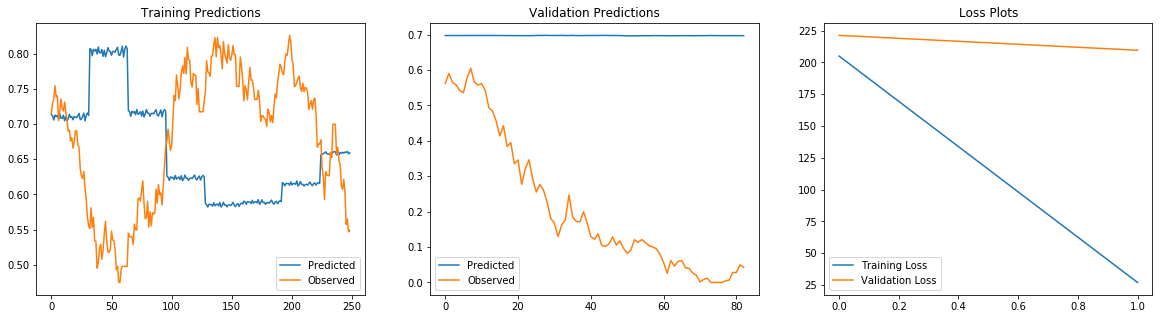

Epoch: 2 Train: 13.15800 Val: 223.43239  Time: 17.609  Best Val: 209.52321


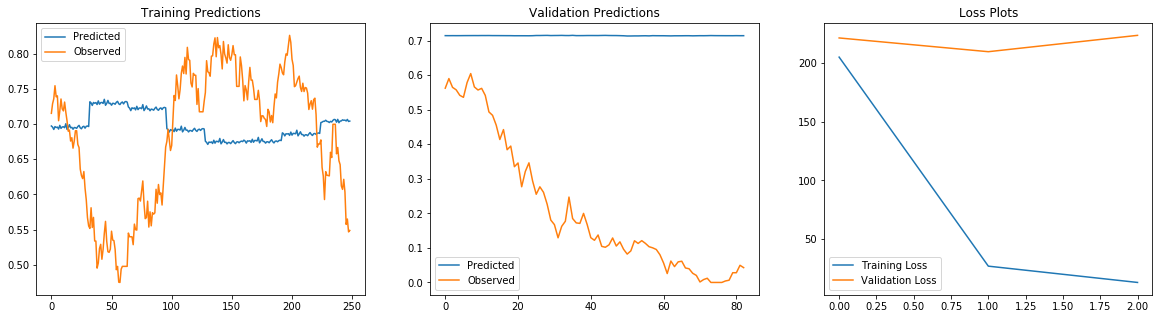

Epoch: 3 Train: 15.40941 Val: 206.85858  Time: 22.569  Best Val: 206.85858


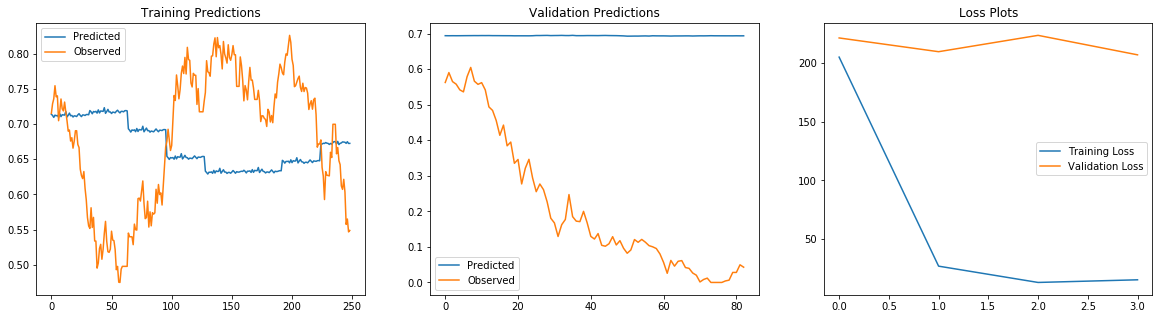

Epoch: 4 Train: 12.58391 Val: 224.45086  Time: 27.462  Best Val: 206.85858


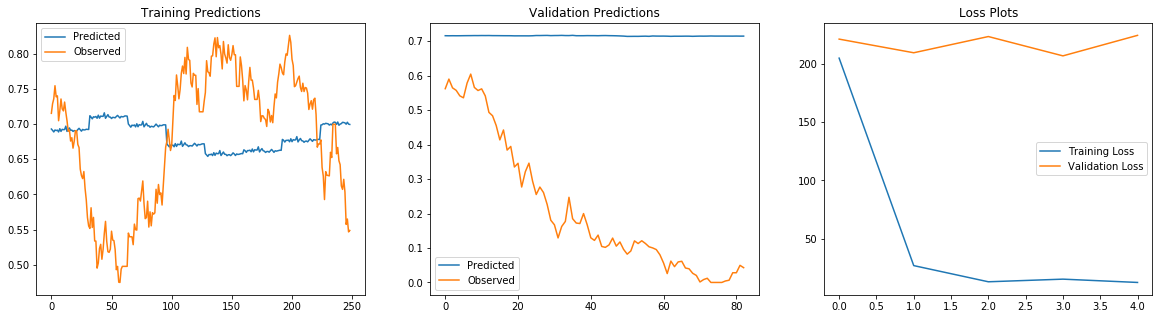

Epoch: 5 Train: 14.89455 Val: 208.62089  Time: 32.485  Best Val: 206.85858


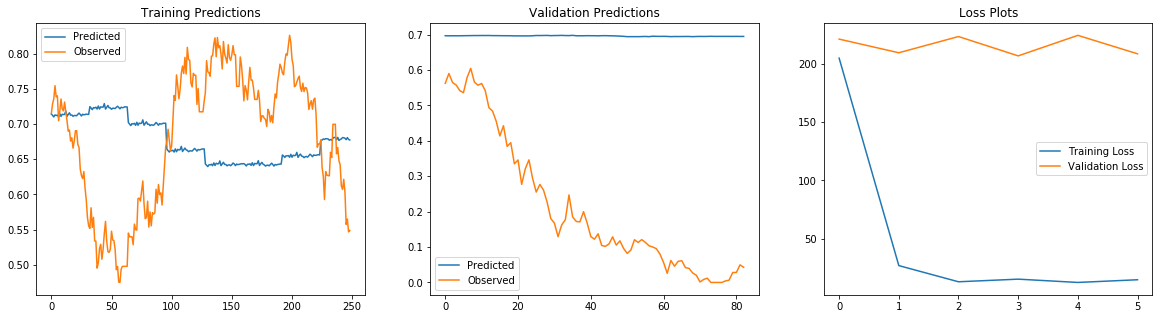

Epoch: 6 Train: 12.93109 Val: 222.98411  Time: 37.384  Best Val: 206.85858


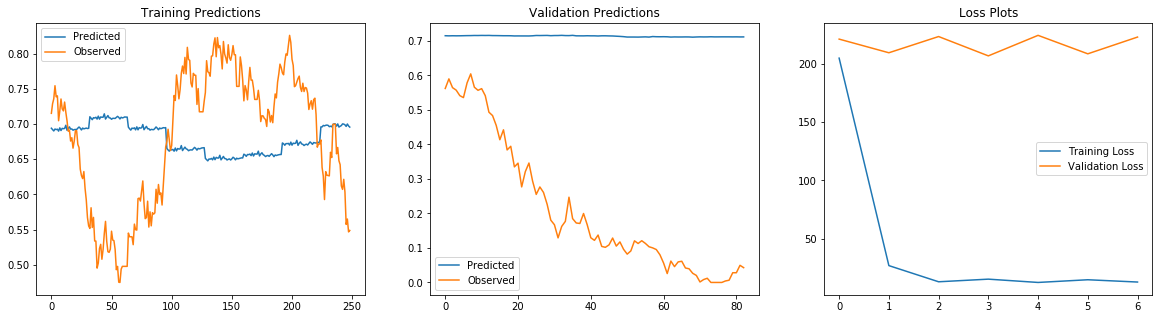

Epoch: 7 Train: 14.58620 Val: 211.22010  Time: 42.285  Best Val: 206.85858


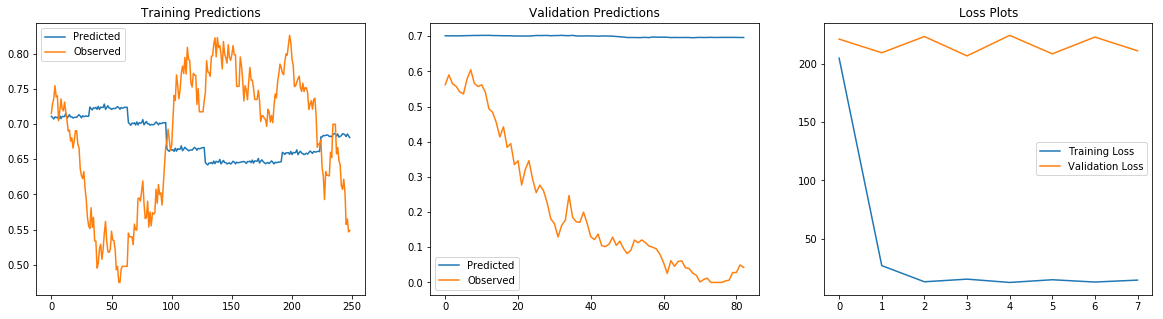

Epoch: 8 Train: 13.14618 Val: 221.61883  Time: 48.724  Best Val: 206.85858


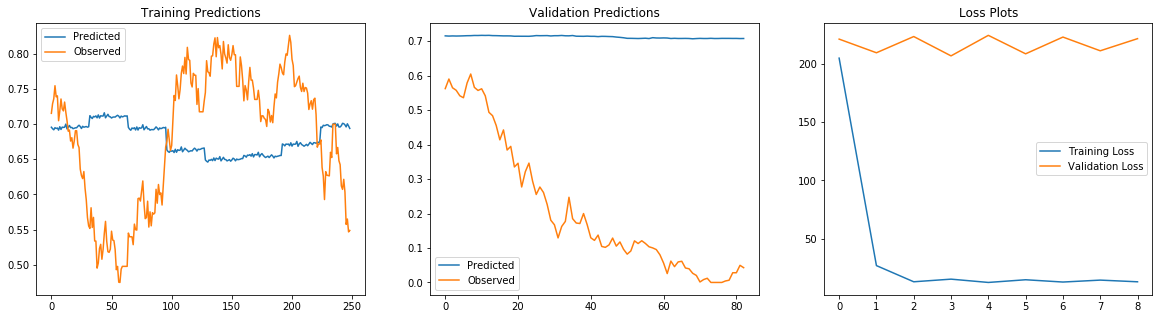

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3

KeyboardInterrupt: 

In [16]:
optimiser = torch.optim.Adam(model.parameters(), learning_rate)

learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=n_epochs,
                        optimiser=optimiser,
                        batch_size=batch_size,
                        debug=False, 
                        disp_freq=disp_freq,
                        fig_disp_freq=fig_disp_freq, 
                        device=device,
                        patience=patience)

# Splitting the data into the train, validation and test sets
learning.train_val_test()
learning.training_wrapper()

In [57]:
# np.concatenate([], learning.inspect)

np.concatenate([np.empty((0, 1)), learning.inspect]).shape

(32, 1)

In [25]:
# learning.create_data_loaders()
print(learning.validate(learning.val_loader))
print(learning.evaluate(learning.best_model, learning.val_loader))

0.8885948296173726
0.8885948296173726


### Saving Model Object

In [0]:
model_name = "Price_Full_Dataset_" + str(forecast_length) + "_"
obj_name = "Learning" + "_" + model_name
pickle.dump(learning, open("/content/gdrive/My Drive/Chai/Models/Pickles/" + obj_name, 'wb'))

In [0]:
# learning_load = pickle.load(open("/content/gdrive/My Drive/Chai/Models/Pickles/" + "learning_object", 'rb'))

In [30]:
model_save(model, 
           path="/content/gdrive/My Drive/Chai/Models/Pths/",
           name= "LSTM" + model_name, 
           val_score=learning.best_val_score)

# mod = model_load(path="Models/Pths",
#            model_name="LSTM_5_854")

Saving model: /content/gdrive/My Drive/Chai/Models/Pths/LSTMPrice_Full_Dataset_22__0_8885.pth


### Plotting

In [0]:
# Scaled Observed
train_true = scaler_data_y.inverse_transform(learning.y_train.numpy().reshape(-1, 1))
val_true  = scaler_data_y.inverse_transform(learning.y_val.numpy().reshape(-1, 1))
test_true  = scaler_data_y.inverse_transform(learning.y_test.numpy().reshape(-1, 1))

# Scaled Predicted
train_pred = scaler_data_y.inverse_transform(np.array(learning.train_predictions).reshape(-1, 1))
val_pred  = scaler_data_y.inverse_transform(np.array(learning.val_predictions).reshape(-1, 1))
test_pred = scaler_data_y.inverse_transform(np.array(learning.test_predictions).reshape(-1, 1))

In [57]:
print(train_true.shape)
print(train_pred.shape)

(1836, 1)
(1836, 1)


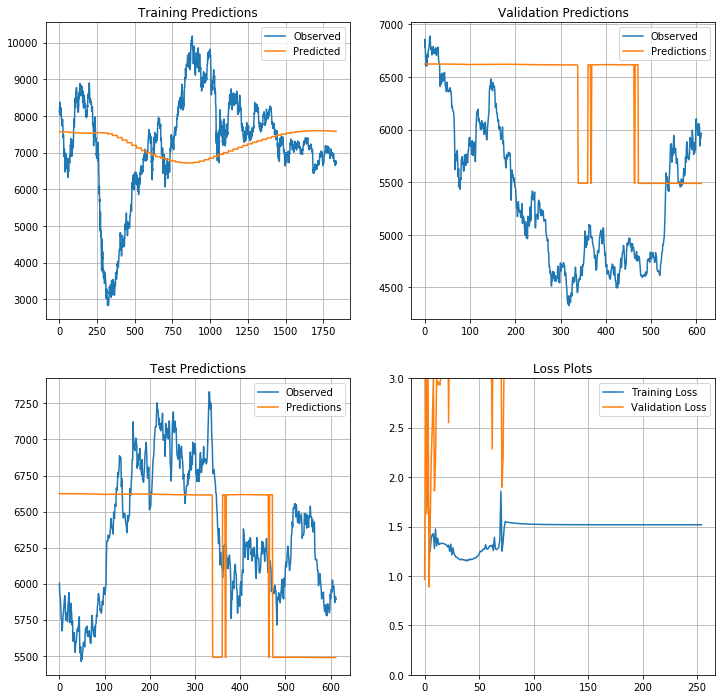

In [32]:
# Rescaling Example
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].set_title("Training Predictions")
ax[0, 0].plot(train_true, label="Observed")
ax[0, 0].plot(train_pred, label="Predicted")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].grid()
ax[0, 1].set_title("Validation Predictions")
ax[0, 1].plot(val_true, label="Observed")
ax[0, 1].plot(val_pred, label="Predictions")
ax[0, 1].legend()

ax[1, 0].grid()
ax[1, 0].set_title("Test Predictions")
ax[1, 0].plot(test_true, label="Observed")
ax[1, 0].plot(test_pred, label="Predictions")
ax[1, 0].legend()

ax[1, 1].grid()
ax[1, 1].set_title("Loss Plots")
ax[1, 1].plot(learning.logs['Training Loss'], label="Training Loss")
ax[1, 1].plot(learning.logs['Validation Loss'], label="Validation Loss")
ax[1, 1].legend()
ax[1, 1].set_ylim((0, 3))

epoch_reached = str(len(learning.logs['Training Loss']))
path="/content/gdrive/My Drive/Chai/Models/"
val_loss = learning.best_val_score

plt.savefig(path + str("LSTM_Val_" + str(val_loss)[:5].replace(".", "_") + "_Epoch_" + epoch_reached + ".png"))

plt.show()

In [0]:
# Log Return Observed
lg_train_true = log_returns(pd.Series(train_true[:, 0]), 1)[1:]
lg_val_true  = log_returns(pd.Series(val_true[:, 0]), 1)[1:]
lg_test_true  = log_returns(pd.Series(test_true[:, 0]), 1)[1:]

# Log Return Predicted
lg_train_pred = log_returns(pd.Series(train_pred[:, 0]), 1)[1:]
lg_val_pred  =log_returns(pd.Series(val_pred[:, 0]), 1)[1:]
lg_test_pred = log_returns(pd.Series(test_pred[:, 0]), 1)[1:]

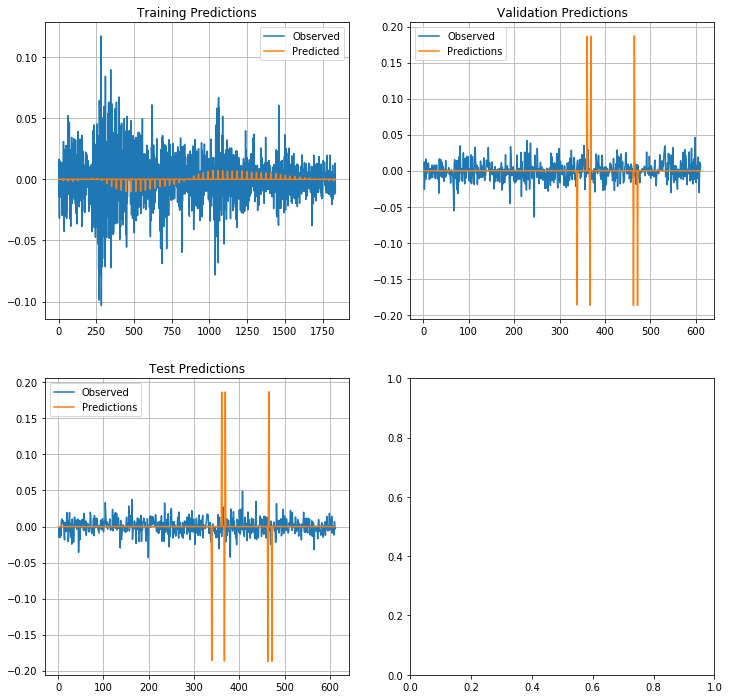

In [42]:
# Rescaling Example
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].set_title("Training Predictions")
ax[0, 0].plot(lg_train_true, label="Observed")
ax[0, 0].plot(lg_train_pred, label="Predicted")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].grid()
ax[0, 1].set_title("Validation Predictions")
ax[0, 1].plot(lg_val_true, label="Observed")
ax[0, 1].plot(lg_val_pred, label="Predictions")
ax[0, 1].legend()

ax[1, 0].grid()
ax[1, 0].set_title("Test Predictions")
ax[1, 0].plot(lg_test_true, label="Observed")
ax[1, 0].plot(lg_test_pred, label="Predictions")
ax[1, 0].legend()

# Results

In [0]:
test_increase = 1e-5 * np.array(range(lg_test_pred.shape[0]))
test_zeros = np.zeros(lg_test_pred.shape)

test_naive = shift(test_true.ravel(), forecast_length)[forecast_length:]

In [47]:
lg_test_pred.shape, lg_test_true.shape

((611,), (612,))

In [43]:
mse, mae, mde = evaluate(lg_test_pred, lg_test_true)
print("Predictions: ", 
      mse, mae, mde)

mse_naive, mae_naive, mde_naive = evaluate(test_naive, test_true[forecast_length:])
print("naive",
    mse_naive, mae_naive, mde_naive)

mse_zeros, mae_zeros, mde_zeros = evaluate(test_zeros, test_true)
print("Flat",
    mse_zeros, mae_zeros, mde_zeros)

mse_increase, mae_increase, mde_increase = evaluate(test_increase, test_true)
print("Inflation",
    mse_increase, mae_increase, mde_increase)

ValueError: ignored

In [0]:
# The minimum validation loss
best_model_epoch = learning.logs['Validation Loss'].index(val_loss)
train_loss = learning.logs['Training Loss'][best_model_epoch]
test_loss = learning.evaluate(learning.best_model, learning.test_loader)

In [0]:
num_epoch = 250
train_time = learning.logs["Time"]
full_save(learning.best_model, 
          "Full_Run",
          optimiser,
          num_epoch, 
          learning_rate, 
          momentum,
          weight_decay, 
          use_lg_returns,
          PCA_used, 
          data_X,
          train_loss,
          val_loss, 
          test_loss,
          train_time, 
          hidden_dim,
          mse,
          mae,
          mde,
          path="/content/gdrive/My Drive/Chai/Models/") 

NameError: ignored

## Persistance

In [0]:
plt.title("Persistance vs Observed Values")
plt.plot(learning.train_predictions, label="Predicted")
plt.plot(shift(learning.train_predictions, 5), label="Observed")
plt.legend()

In [0]:
df = df_full[["target"]]
# Taking t-1 to be the value for t
df["persistance"] = df.shift(1)
df.dropna(inplace=True)
# Calculating metrics for these columns
MSE, MAE, MDE = evaluate(df, "target", "persistance")

In [0]:
print(df[:5])
print(df[-5:])

In [0]:
# Placing in results dataframe
results = pd.DataFrame(columns={"MSE", "MAE", "MDE"})
results.index.name = 'Name'
results.head()
results.loc["persistance"] = [MSE, MAE, MDE] 
results.head()